In [1]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero

from HeteroDataFunctions import Encoder, add_types, complete_graph, flatten_lol, node_cat_dict, midi_type

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

1.13.1


In [2]:
# Complete Dataset
G = complete_graph(".\slac\embeddings\\all")

loading edgelists...
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 93553
Edges: 786635


In [3]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [4]:
node_categories = node_cat_dict(nodes)
node_categories.keys()

node_cat_dict took 0.29 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [5]:
%%script false --no- raise -error

nodes_df_complete, edges_df_complete = add_types(nodes, edges, node_categories)

winsound.Beep(400, 700)

nodes_df_complete.to_csv('nodes_complete.csv')
edges_df_complete.to_csv('edges_complete.csv')

Couldn't find program: 'false'


In [6]:
nodes_df_complete = pd.read_csv('.\slac\Contents of Slac\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\slac\Contents of Slac\edges_complete.csv')
print('Done')

Done


In [7]:
node_types = set(nodes_df_complete['node_type'])
node_types


{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [8]:
edge_types = ["MIDI__has__tempo",
                   "MIDI__in__time_sig",
                   "MIDI__has__program",
                   "MIDI__has__note_group",
                   "note_group__has__velocity",
                   "note_group__has__duration",
                   "note_group__contains__pitch"]

In [9]:
names_list = flatten_lol(node_categories.values())


In [10]:
encoder = Encoder(names_list, n_labels=10)


In [11]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 0.05 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.01 secs to run
encode_nodes took 0.02 secs to run
encode_nodes took 5.89 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.01 secs to run


In [12]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [13]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [14]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values
midi_class_5 = [midi_type(s[0], 5) for s in midi_val]

lb = LabelEncoder()
y_5 = torch.from_numpy(lb.fit_transform(midi_class_5)) # .type(torch.LongTensor)

lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [15]:
input_node_dict_5 = input_node_dict.copy()

input_node_dict_5['MIDI']['y'] = y_5

In [16]:
H_5 = HeteroData(input_node_dict_5, **input_edge_dict)

In [17]:
print(H_5)

HeteroData(
  duration={ x=[570, 1] },
  velocity={ x=[11, 1] },
  program={ x=[108, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  pitch={ x=[93, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [18]:
H_5 = T.ToUndirected()(H_5)

In [19]:
H_5 = T.RandomNodeSplit(num_val=22, num_test=25)(H_5)

In [20]:
print(H_5)

HeteroData(
  duration={ x=[570, 1] },
  velocity={ x=[11, 1] },
  program={ x=[108, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  pitch={ x=[93, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [21]:
H_5['MIDI'].test_mask

tensor([False, False, False, False, False, False,  True, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, 

# GNN

In [22]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model_5 = GCN(hidden_channels=32, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')
# model_5 = torch_geometric.compile(model_5)

In [23]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
# optimizer = getattr(torch.optim, optimizer_name)(model_5.parameters(), lr=lr)


In [24]:
def train5():
    model_5.train()
    optimizer.zero_grad()
    out = model_5(H_5.x_dict, H_5.edge_index_dict)
    mask = H_5['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_5['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [25]:
@torch.no_grad()
def test5():
    model_5.eval()
    pred = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []
    for mask in [H_5['MIDI'].train_mask, H_5['MIDI'].val_mask, H_5['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_5['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [26]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []
for epoch in range(1, 401):
    loss = train5()
    train_acc, val_acc, test_acc = test5()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 249896.1562, Train: 0.2020, Val: 0.2273, Test: 0.1600
Epoch: 002, Loss: 61454.2422, Train: 0.2020, Val: 0.1818, Test: 0.2000
Epoch: 003, Loss: 102118.4062, Train: 0.3695, Val: 0.4545, Test: 0.4800
Epoch: 004, Loss: 100495.7109, Train: 0.2020, Val: 0.1818, Test: 0.2000
Epoch: 005, Loss: 171487.8438, Train: 0.2020, Val: 0.1818, Test: 0.2000
Epoch: 006, Loss: 138114.5938, Train: 0.2069, Val: 0.2727, Test: 0.2800
Epoch: 007, Loss: 94689.9922, Train: 0.1823, Val: 0.2727, Test: 0.2800
Epoch: 008, Loss: 57947.8125, Train: 0.2118, Val: 0.1818, Test: 0.2000
Epoch: 009, Loss: 68893.9531, Train: 0.2414, Val: 0.1818, Test: 0.2000
Epoch: 010, Loss: 54755.7031, Train: 0.3448, Val: 0.2273, Test: 0.2000
Epoch: 011, Loss: 43791.4102, Train: 0.3350, Val: 0.3182, Test: 0.2400
Epoch: 012, Loss: 66153.0234, Train: 0.2512, Val: 0.1818, Test: 0.2000
Epoch: 013, Loss: 73909.8750, Train: 0.2906, Val: 0.2727, Test: 0.2000
Epoch: 014, Loss: 65845.1484, Train: 0.3350, Val: 0.3636, Test: 0.2400
E

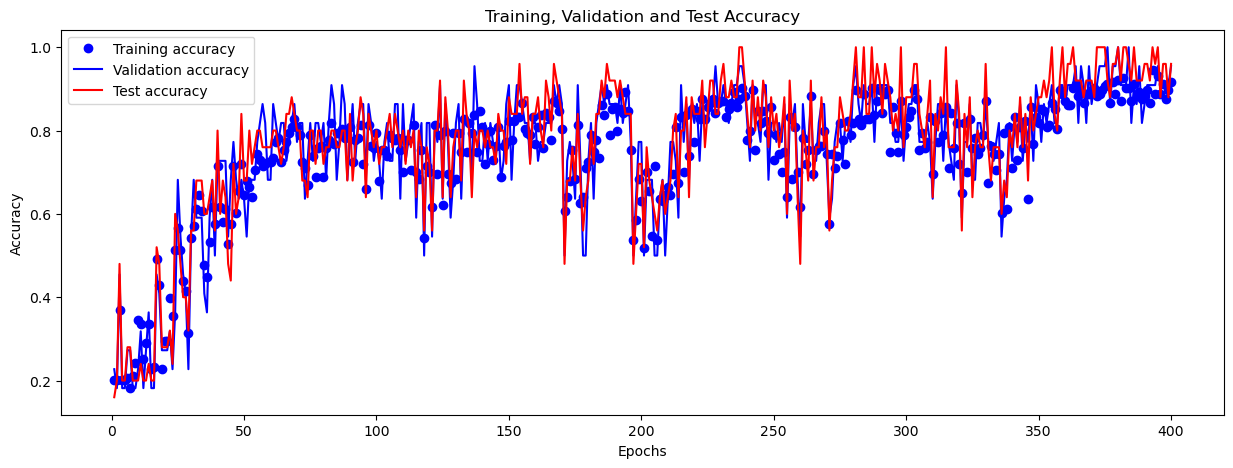

In [27]:
epochs = range(1, len(acc_lists['train']) + 1)

fig = plt.figure(figsize=(15, 5))

plt.plot(epochs, acc_lists['train'], 'bo', label='Training accuracy')
plt.plot(epochs, acc_lists['val'], 'b', label='Validation accuracy')
plt.plot(epochs, acc_lists['test'], 'r', label='Test accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.show()

## 10 class

In [28]:
nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']]

,name
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...
1029,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get
2248,Blues_-_Modern-B_B_King_-_Rock_Me_Baby
2686,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone
3738,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door
...,...
92865,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...
92925,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...
93030,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...
93133,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...


In [29]:
set([midi_type(s[0], 10) for s in midi_val])

{'Alternative',
 'Baroque',
 'Bop',
 'Hardcore_Rap',
 'Metal',
 'Modern',
 'Pop_Rap',
 'Romantic',
 'Swing',
 'Traditional'}

In [30]:
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb_10 = LabelEncoder()
y_10 = torch.from_numpy(lb_10.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb_10.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [31]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

In [32]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict)

In [33]:
print(H_10)

HeteroData(
  duration={ x=[570, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  program={ x=[108, 1] },
  note_group={ x=[92484, 1] },
  time_sig={ x=[14, 1] },
  pitch={ x=[93, 1] },
  velocity={ x=[11, 1] },
  tempo={ x=[23, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [34]:
H_10 = T.ToUndirected()(H_10)

In [35]:
H_10 = T.RandomNodeSplit(num_val=22, num_test=25)(H_10)

In [36]:
print(H_10)

HeteroData(
  duration={ x=[570, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  program={ x=[108, 1] },
  note_group={ x=[92484, 1] },
  time_sig={ x=[14, 1] },
  pitch={ x=[93, 1] },
  velocity={ x=[11, 1] },
  tempo={ x=[23, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [37]:
H_10['MIDI'].test_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, 

In [83]:
model_10 = GCN(hidden_channels=32, out_channels=len(set(lb_10.classes_)))
model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')

In [84]:
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.01)

In [85]:
def train10():
    model_10.train()
    optimizer_10.zero_grad()
    out = model_10(H_10.x_dict, H_10.edge_index_dict)
    mask = H_10['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_10['MIDI'].y[mask])
    loss.backward()
    optimizer_10.step()
    return float(loss)

In [86]:
@torch.no_grad()
def test10():
    model_10.eval()
    pred = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []
    for mask in [H_10['MIDI'].train_mask, H_10['MIDI'].val_mask, H_10['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_10['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [88]:
acc_lists = {'train': [], 'val': [], 'test': []}
for epoch in range(1, 401):
    loss = train10()
    train_acc, val_acc, test_acc = test10()
    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 211322.6406, Train: 0.1773, Val: 0.3636, Test: 0.1200
Epoch: 002, Loss: 167886.8125, Train: 0.1675, Val: 0.4091, Test: 0.1600
Epoch: 003, Loss: 167208.8125, Train: 0.1281, Val: 0.2727, Test: 0.1600
Epoch: 004, Loss: 121109.5000, Train: 0.1330, Val: 0.1818, Test: 0.1600
Epoch: 005, Loss: 120048.9297, Train: 0.1823, Val: 0.1364, Test: 0.2000
Epoch: 006, Loss: 114696.5781, Train: 0.2020, Val: 0.1364, Test: 0.2400
Epoch: 007, Loss: 97426.0312, Train: 0.2906, Val: 0.2727, Test: 0.2800
Epoch: 008, Loss: 88606.6875, Train: 0.1872, Val: 0.1818, Test: 0.2800
Epoch: 009, Loss: 97172.3516, Train: 0.1675, Val: 0.1818, Test: 0.2400
Epoch: 010, Loss: 91048.3125, Train: 0.2906, Val: 0.0455, Test: 0.2400
Epoch: 011, Loss: 77545.4609, Train: 0.3153, Val: 0.1364, Test: 0.2000
Epoch: 012, Loss: 85499.2188, Train: 0.2266, Val: 0.0909, Test: 0.0800
Epoch: 013, Loss: 93213.7969, Train: 0.2069, Val: 0.0909, Test: 0.0800
Epoch: 014, Loss: 84096.2969, Train: 0.2118, Val: 0.1818, Test: 0.0400


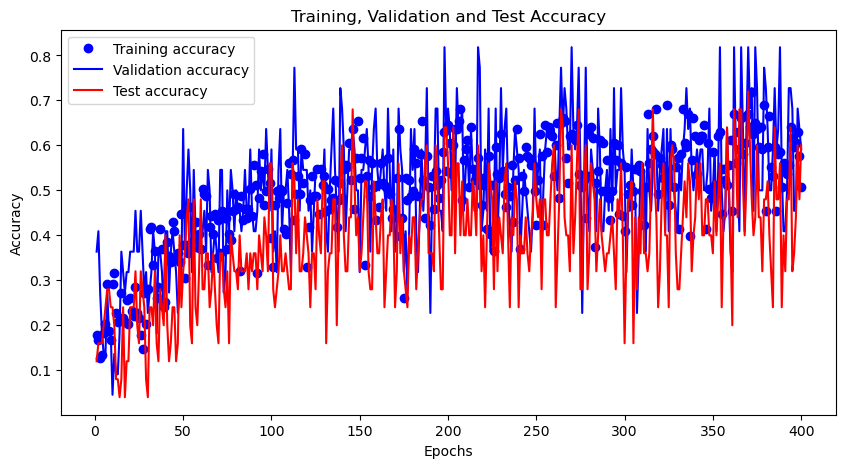

In [89]:
epochs = range(1, len(acc_lists['train']) + 1)

fig = plt.figure(figsize=(10, 5))

plt.plot(epochs, acc_lists['train'], 'bo', label='Training accuracy')
plt.plot(epochs, acc_lists['val'], 'b', label='Validation accuracy')
plt.plot(epochs, acc_lists['test'], 'r', label='Test accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.show()

 # Old Implementation

In [44]:
# nodes_ten_ = encoder.encode_nodes(nodes_df_complete)
# edges_ten_ = encoder.encode_edges(edges_df_complete)

# node_type_ = nodes_df_complete.iloc[:, 1]

# Get the source and target indices from the edges tensor
# edge_index = edges_ten_[:, :2]

## Get the edge types from the edges tensor
#edge_type_ = edges_df_complete.iloc[:, 2]

#full_hetero_graph = HeteroData(x=nodes_ten_, node_type=node_type_, edge_index=edge_index, edge_type=edge_type_)

In [45]:
# edges_df_complete.loc[edges_df_complete['edge_type'] == 'MIDI__has__tempo', ['source', 'target']]

In [46]:
# full_categories = node_categories.copy()
# full_categories['node_types'] = list(node_categories.keys())
# full_categories['edge_types'] = edge_types  # Dictionary containing every string that may be found in our Dataframes
# names_list_full = flatten_lol(full_categories.values())

In [47]:
# input_edge_dict = {edge_type: {'edge_index': encoder.encode_edges(edges_df_complete.loc[
#                    edges_df_complete['edge_type'] == edge_type, ['source', 'target']])} for edge_type in edge_types}
# for key in input_edge_dict.keys():
#     input_edge_dict[key]['edge_index'] = input_edge_dict[key]['edge_index'].T.to(torch.int64)
